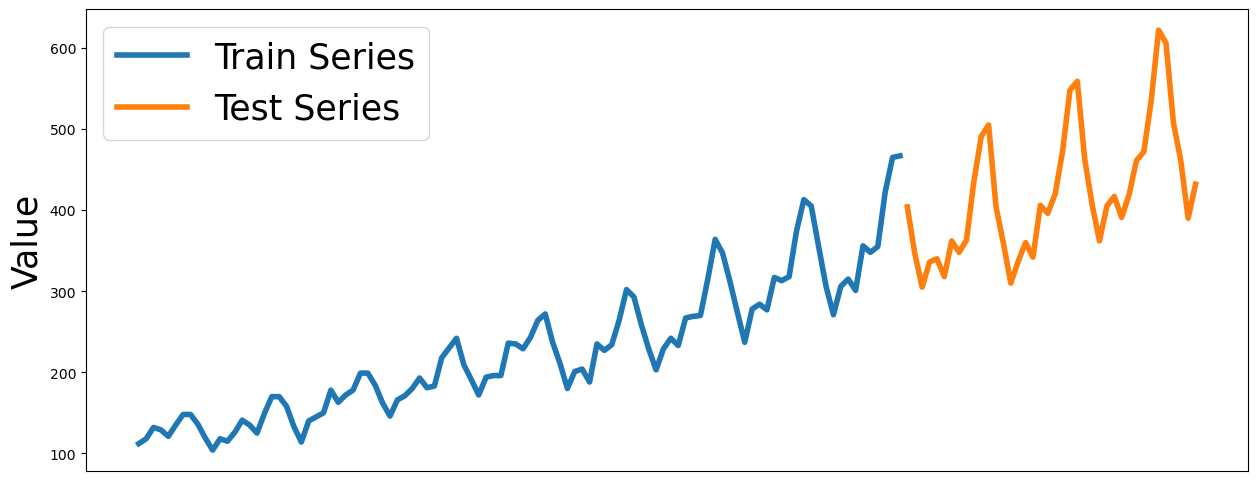

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv')

#transform dataset into the prophet input format
df['ds']=df['Month']
df['y'] = df['#Passengers']

Test_size = int(40) #last 40 values
train_df = df.head(len(df)-Test_size)
test_df = df.tail(Test_size) 

from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(train_df['ds'], train_df['y'], linewidth = 4, label = "Train Series")
plt.plot(test_df['ds'], test_df['y'], linewidth = 4, label = "Test Series")


plt.legend(fontsize=25)
plt.ylabel('Value', fontsize = 25)
plt.xticks([])
plt.show()

c:\Users\Wenlei\Anaconda3\envs\time_series\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
22:56:02 - cmdstanpy - INFO - Chain [1] start processing
22:56:02 - cmdstanpy - INFO - Chain [1] done processing


error is: 11.78


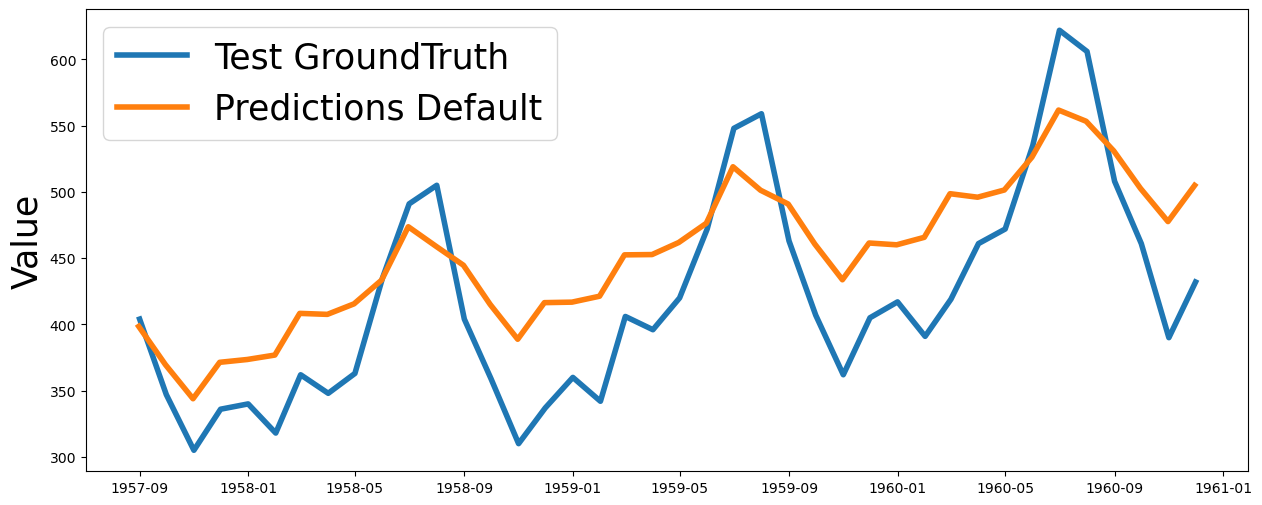

In [2]:
#without tuning as baseline
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

#default model training
from prophet import Prophet
model = Prophet()
model.fit(train_df)
future = model.make_future_dataframe(periods=Test_size, freq='M')
forecast = model.predict(future)
predictions = forecast.tail(Test_size)

error = mape(test_df['y'], predictions['yhat'])   
print('error is:', error)


from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.plot(pd.to_datetime(test_df['ds']), test_df['y'], linewidth = 4, label = "Test GroundTruth")
plt.plot(pd.to_datetime(predictions['ds']), predictions['yhat'], linewidth = 4, label = "Predictions Default")

plt.legend(fontsize=25)
plt.ylabel('Value', fontsize = 25)
plt.show()

In [3]:
#use mango to tune and predict 
#define loss function 

from scipy.stats import uniform
from prophet import Prophet
from mango import scheduler, Tuner

#objective function
def objective_function(args_list):
    global train_df, test_df
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=Test_size, freq='M')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(Test_size)
            error = mape(test_df['y'], predictions_tuned['yhat'])   
            
            params_evaluated.append(params)
            results.append(error)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(25.0)# Giving high loss for exceptions regions of spaces
        
        #print(params_evaluated, mse)
    return params_evaluated, results

#search space
param_space = dict(growth = ['linear', 'logistic', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000]
                   )

conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 50

tuner = Tuner(param_space, objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

20:33:50 - cmdstanpy - INFO - Chain [1] start processing
20:33:50 - cmdstanpy - INFO - Chain [1] done processing
20:33:50 - cmdstanpy - INFO - Chain [1] start processing
20:33:50 - cmdstanpy - INFO - Chain [1] done processing
20:33:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:33:50 - cmdstanpy - INFO - Chain [1] start processing
20:33:51 - cmdstanpy - INFO - Chain [1] done processing
20:33:51 - cmdstanpy - INFO - Chain [1] start processing
20:33:51 - cmdstanpy - INFO - Chain [1] done processing
20:33:51 - cmdstanpy - INFO - Chain [1] start processing
20:33:51 - cmdstanpy - INFO - Chain [1] done processing
20:33:51 - cmdstanpy - INFO - Chain [1] start processing
20:33:51 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing
20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start process

best parameters: {'changepoint_prior_scale': 0.09451555341208774, 'changepoint_range': 0.613477927100557, 'daily_seasonality': True, 'growth': 'linear', 'interval_width': 0.2552143633326807, 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.002943289636024, 'uncertainty_samples': 500, 'weekly_seasonality': False, 'yearly_seasonality': True}
best loss: 5.94


In [9]:
#use best param to predict
results = dict()
results['best_params'] = {'changepoint_prior_scale': 0.09451555341208774, 'changepoint_range': 0.613477927100557, 'daily_seasonality': True, 'growth': 'linear', 'interval_width': 0.2552143633326807, 'n_changepoints': 0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.002943289636024, 'uncertainty_samples': 500, 'weekly_seasonality': False, 'yearly_seasonality': True}
model = Prophet(**results['best_params'])
model.fit(train_df)
future = model.make_future_dataframe(periods=Test_size, freq='M')
forecast = model.predict(future)
predictions_tuned = forecast.tail(Test_size)
predictions_tuned['yhat'].head() 

23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing
23:27:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:27:57 - cmdstanpy - INFO - Chain [1] start processing
23:27:57 - cmdstanpy - INFO - Chain [1] done processing


104    381.244032
105    328.726873
106    277.722651
107    322.662581
108    328.096458
Name: yhat, dtype: float64

In [5]:
#https://github.com/ARM-software/mango?tab=readme-ov-file  about failure and cross validation use cross_val_score
#notice time series cannot use regular cross validation
#create a def can display as many line as it has

def plot_time_series_line_chart (title, **kwags):

    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)

    for k, v in kwags.items():
        plt.plot(v[0], v[1], linewidth = 4, label = f"{k}")
        #plt.plot(train_df['ds'], train_df['y'], linewidth = 4, label = "Train Series")
        #plt.plot(test_df['ds'], test_df['y'], linewidth = 4, label = "Test Series")


    plt.legend(fontsize=25)
    plt.ylabel('Value', fontsize = 25)
    plt.title(title)
    plt.xticks([])
    plt.show()


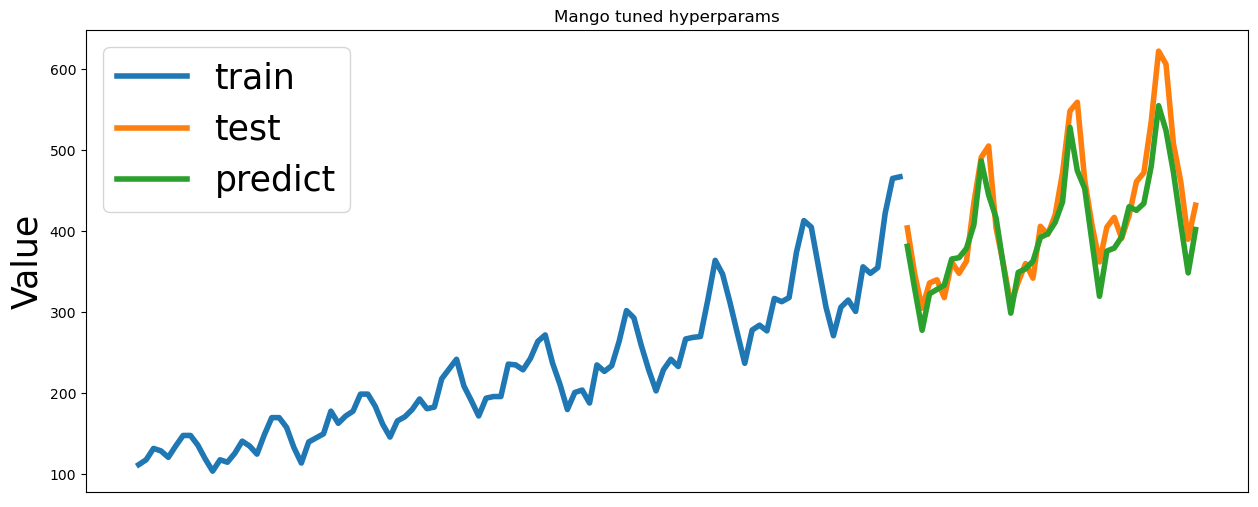

In [10]:
#plot the result together with original
dict_result ={
    'train':[train_df['ds'], train_df['y']],
    'test':[test_df['ds'], test_df['y']],
    'predict':[test_df['ds'], predictions_tuned['yhat']]
}
plot_time_series_line_chart('Mango tuned hyperparams', **dict_result)

In [4]:
#use optuna
import optuna
def objective(trial):

    Test_size = 40
    
    param_space = {

        #"n_changepoints":trial.suggest_categorical("n_changepoints", ['linear', 'logistic', 'flat']),
        "n_changepoints":trial.suggest_int("n_changepoints", 0, 55, 5),
        "changepoint_range":trial.suggest_uniform("changepoint_range", 0.5, 0.5),
        'yearly_seasonality': trial.suggest_categorical('yearly_seasonality',[True, False]),
        'weekly_seasonality': trial.suggest_categorical('weekly_seasonality',[True, False]),  
        'daily_seasonality': trial.suggest_categorical('daily_seasonality',[True, False]), 
        "seasonality_mode":trial.suggest_categorical("seasonality_mode", ['additive', 'multiplicative']),
        "seasonality_prior_scale":trial.suggest_uniform("seasonality_prior_scale", 5, 15),
        "changepoint_prior_scale":trial.suggest_uniform("changepoint_prior_scale", 0, 0.1),
        "interval_width":trial.suggest_uniform("interval_width", 0.2, 0.8),
        'uncertainty_samples': trial.suggest_categorical('uncertainty_samples',[500, 1000, 1500, 2000]), 
    }

    model = Prophet(**param_space)
    model.fit(train_df)
    future = model.make_future_dataframe(periods=Test_size, freq='M')
    forecast = model.predict(future)
    predictions_tuned = forecast.tail(Test_size)
    error = mape(test_df['y'], predictions_tuned['yhat'])  
   
    
    return error



study = optuna.create_study(direction="minimize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_value, study.best_params) 


[I 2024-11-23 23:22:04,461] A new study created in memory with name: no-name-87e4c0b8-15b0-4e4a-a3c0-a04899c1434a
23:22:04 - cmdstanpy - INFO - Chain [1] start processing
23:22:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-23 23:22:04,834] Trial 0 finished with value: 4.2 and parameters: {'n_changepoints': 50, 'changepoint_range': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.206353046826276, 'changepoint_prior_scale': 0.09714647750315751, 'interval_width': 0.40865238823287225, 'uncertainty_samples': 500}. Best is trial 0 with value: 4.2.
23:22:05 - cmdstanpy - INFO - Chain [1] start processing
23:22:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-23 23:22:05,224] Trial 1 finished with value: 11.88 and parameters: {'n_changepoints': 40, 'changepoint_range': 0.5, 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 's

3.86 {'n_changepoints': 25, 'changepoint_range': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.46159558713627, 'changepoint_prior_scale': 0.020657757565973905, 'interval_width': 0.20511250390529134, 'uncertainty_samples': 500}


In [11]:
model = Prophet(**study.best_params)
model.fit(train_df)
future = model.make_future_dataframe(periods=Test_size, freq='M')
forecast = model.predict(future)
predictions_tuned = forecast.tail(Test_size)
predictions_tuned['yhat'].head() 

23:28:52 - cmdstanpy - INFO - Chain [1] start processing
23:28:52 - cmdstanpy - INFO - Chain [1] done processing


104    385.593204
105    336.911841
106    295.759711
107    337.458549
108    345.314166
Name: yhat, dtype: float64

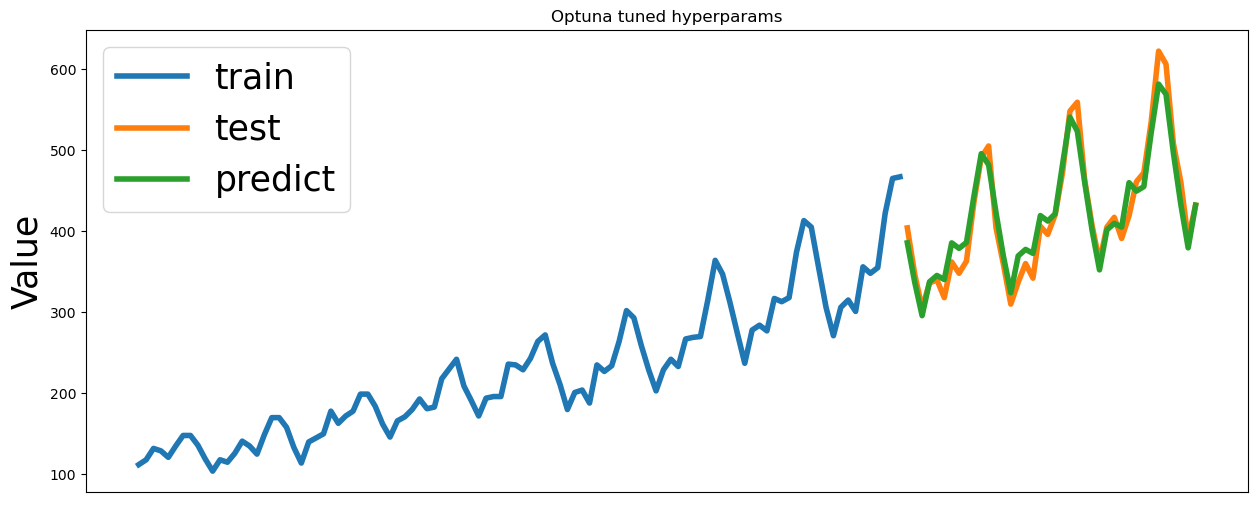

In [12]:
dict_result ={
    'train':[train_df['ds'], train_df['y']],
    'test':[test_df['ds'], test_df['y']],
    'predict':[test_df['ds'], predictions_tuned['yhat']]
}
plot_time_series_line_chart('Optuna tuned hyperparams', **dict_result)

In [13]:
import optuna
res = []
def objective(trial):    
    
    prediction_horizon_param = {
        "prediction_horizon": trial.suggest_int("prediction_horizon", 5, 40, 5)
    } 

    param_space = {     
                
        "n_changepoints":trial.suggest_int("n_changepoints", 0, 55, 5),
        "changepoint_range":trial.suggest_uniform("changepoint_range", 0.5, 0.5),
        'yearly_seasonality': trial.suggest_categorical('yearly_seasonality',[True, False]),
        'weekly_seasonality': trial.suggest_categorical('weekly_seasonality',[True, False]),  
        'daily_seasonality': trial.suggest_categorical('daily_seasonality',[True, False]), 
        "seasonality_mode":trial.suggest_categorical("seasonality_mode", ['additive', 'multiplicative']),
        "seasonality_prior_scale":trial.suggest_uniform("seasonality_prior_scale", 5, 15),
        "changepoint_prior_scale":trial.suggest_uniform("changepoint_prior_scale", 0, 0.1),
        "interval_width":trial.suggest_uniform("interval_width", 0.2, 0.8),
        'uncertainty_samples': trial.suggest_categorical('uncertainty_samples',[500, 1000, 1500, 2000]), 
    }

    model = Prophet(**param_space)
    model.fit(train_df)
    Test_size = prediction_horizon_param["prediction_horizon"]
    future = model.make_future_dataframe(periods=Test_size, freq='M')
    forecast = model.predict(future)
    predictions_tuned = forecast.tail(Test_size)
    error = mape(test_df['y'][:Test_size], predictions_tuned['yhat'])  
    res.append([Test_size, error]) 
    
    return error

study = optuna.create_study(direction="minimize") # maximise the score during tuning
study.optimize(objective, n_trials=800) # run the objective function 800 times
print(study.best_value, study.best_params) 



[I 2024-11-23 23:41:06,888] A new study created in memory with name: no-name-34a9dcf1-bda0-48a4-b15a-d0870bf9d888
23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:07 - cmdstanpy - INFO - Chain [1] done processing
23:41:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:41:07 - cmdstanpy - INFO - Chain [1] start processing
23:41:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Wenlei\AppData\Local\Temp\ipykernel_11740\3053051970.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  error = mape(test_df['y'][:Test_size], predictions_tuned['yhat'])
[I 2024-11-23 23:41:07,595] Trial 0 finished with value: 12.44 an

0.81 {'prediction_horizon': 5, 'n_changepoints': 5, 'changepoint_range': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 13.669332889345846, 'changepoint_prior_scale': 0.0995517709685246, 'interval_width': 0.4342396621854417, 'uncertainty_samples': 1000}


In [18]:
df_results = pd.DataFrame(res, columns=['predict_horizon', 'error'])
df_results.sort_values(by=['error'])

,predict_horizon,error
374,5,0.81
591,5,0.85
600,5,0.86
696,5,0.86
523,5,0.87
...,...,...
4,40,13.43
501,10,13.56
1,15,13.60
423,5,13.69


In [19]:
df_results.to_csv(r'D:\data science data\mango_output.csv')

In [20]:
df_results.groupby('predict_horizon').agg('mean')

,error
predict_horizon,
5,2.362573
10,5.145439
15,5.873333
20,7.358182
25,7.663000
30,5.904444
35,4.647143
40,6.262857


<AxesSubplot: xlabel='predict_horizon'>

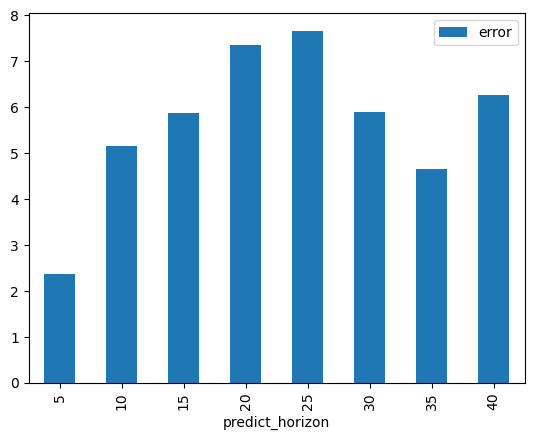

In [22]:
df_results.groupby('predict_horizon').agg('mean').plot(kind= 'bar')

In [23]:
res = []
def objective(trial):    
    
    prediction_horizon_param = {
        "prediction_horizon": trial.suggest_int("prediction_horizon", 5, 40, 5)
    } 

    param_space = {     
                
        "n_changepoints":trial.suggest_int("n_changepoints", 0, 55, 5),
        "changepoint_range":trial.suggest_uniform("changepoint_range", 0.5, 0.5),
        'yearly_seasonality': trial.suggest_categorical('yearly_seasonality',[True, False]),
        'weekly_seasonality': trial.suggest_categorical('weekly_seasonality',[True, False]),  
        'daily_seasonality': trial.suggest_categorical('daily_seasonality',[True, False]), 
        "seasonality_mode":trial.suggest_categorical("seasonality_mode", ['additive', 'multiplicative']),
        "seasonality_prior_scale":trial.suggest_uniform("seasonality_prior_scale", 5, 15),
        "changepoint_prior_scale":trial.suggest_uniform("changepoint_prior_scale", 0, 0.1),
        "interval_width":trial.suggest_uniform("interval_width", 0.2, 0.8),
        'uncertainty_samples': trial.suggest_categorical('uncertainty_samples',[500, 1000, 1500, 2000]), 
    }

    model = Prophet(**param_space)
    model.fit(train_df)
    Test_size = prediction_horizon_param["prediction_horizon"]
    future = model.make_future_dataframe(periods=Test_size, freq='M')
    forecast = model.predict(future)
    predictions_tuned = forecast.tail(Test_size)
    error = mape(test_df['y'][:5], predictions_tuned['yhat'][:5])  
    res.append([Test_size, error]) 
    
    return error

study = optuna.create_study(direction="minimize") # maximise the score during tuning
study.optimize(objective, n_trials=800) # run the objective function 800 times
print(study.best_value, study.best_params) 

[I 2024-11-23 23:59:51,382] A new study created in memory with name: no-name-067e6f4a-b53a-4910-a213-27c6cc05d844
23:59:51 - cmdstanpy - INFO - Chain [1] start processing
23:59:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Wenlei\AppData\Local\Temp\ipykernel_11740\3375923147.py:28: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  error = mape(test_df['y'][:5], predictions_tuned['yhat'][:5])
[I 2024-11-23 23:59:51,790] Trial 0 finished with value: 2.03 and parameters: {'prediction_horizon': 40, 'n_changepoints': 40, 'changepoint_range': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.99797840752741, 'changepoint_prio

0.86 {'prediction_horizon': 40, 'n_changepoints': 5, 'changepoint_range': 0.5, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.755647909940238, 'changepoint_prior_scale': 0.08758596812634192, 'interval_width': 0.39184268486704343, 'uncertainty_samples': 1500}


In [24]:
df_results2 = pd.DataFrame(res, columns=['predict_horizon', 'error'])
df_results2.sort_values(by=['error'])

,predict_horizon,error
483,40,0.86
406,40,0.86
386,40,0.86
651,30,0.87
366,40,0.87
...,...,...
518,40,12.85
360,40,12.86
379,40,12.88
337,40,12.89


In [25]:
df_results2.to_csv(r'D:\data science data\mango_output2.csv')

In [26]:
df_results.groupby('predict_horizon').agg('mean')

,error
predict_horizon,
5,2.362573
10,5.145439
15,5.873333
20,7.358182
25,7.663000
30,5.904444
35,4.647143
40,6.262857


In [28]:
df_results2.sort_values(by=['error'])[:50]

,predict_horizon,error
483,40,0.86
406,40,0.86
386,40,0.86
651,30,0.87
366,40,0.87
384,40,0.87
265,40,0.90
547,40,0.90
279,40,0.91
537,40,0.92


In [21]:
np.linspace(5,40,8)

array([ 5., 10., 15., 20., 25., 30., 35., 40.])

In [ ]:
#what if I want to see prediction horizon impact to the 

prediction_horizon_param_space = dict(
                   prediction_horizon = np.linspace(5,40,8),   #add this to test different size of horizon
                   model_params = dict(growth = ['linear', 'logistic', 'flat'],
                   n_changepoints  = range(0, 55, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000])
                   )

In [44]:
res = []
def objective_function2(args_list):
    global train_df, test_df
    error=0   
    
    results = []
    params_evaluated = []
    
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_df)
            future = model.make_future_dataframe(periods=Test_size, freq='M')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(Test_size)
            error = mape(test_df['y'][:5], predictions_tuned['yhat'][:5])   
            res.append((Test_size, error))
            params_evaluated.append( params)
            results.append(error)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append( params)
            results.append(25.0)# Giving high loss for exceptions regions of spaces
        
        #print(params_evaluated, mse)
    return params_evaluated, results

for Test_size in list(np.linspace(5,40,8))[::-1]:

    conf_Dict = dict()
    conf_Dict['initial_random'] = 10
    conf_Dict['num_iteration'] = 50

    tuner = Tuner(param_space, objective_function2, conf_Dict)
    results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [43]:
for Test_size in list(np.linspace(5,40,8)):
    print(Test_size)


5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0


In [33]:
Test_size = 5
model = Prophet(**results['best_params'])
model.fit(train_df)
future = model.make_future_dataframe(periods=Test_size, freq='M')
forecast = model.predict(future)
predictions_tuned = forecast.tail(Test_size)
error = mape(test_df['y'][:5], predictions_tuned['yhat'][:5])  
error 


22:13:32 - cmdstanpy - INFO - Chain [1] start processing
22:13:32 - cmdstanpy - INFO - Chain [1] done processing
22:13:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:13:32 - cmdstanpy - INFO - Chain [1] start processing
22:13:32 - cmdstanpy - INFO - Chain [1] done processing


5.46

In [30]:
params_evaluated

NameError: name 'params_evaluated' is not defined

In [23]:
def objective_function_horizon(args_list):
    global train_df, test_df
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            model = Prophet(**params['model_params'])
            model.fit(train_df)
            Test_size=params['prediction_horizon']   #this became a variable, to see which one perform best
            future = model.make_future_dataframe(periods=Test_size, freq='M')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(Test_size)
            error = mape(test_df['y'][:Test_size], predictions_tuned['yhat'])   
            
            params_evaluated.append((params, error))
            results.append(error)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append((params, error))
            results.append(25.0)# Giving high loss for exceptions regions of spaces
        
        #print(params_evaluated, mse)
    return params_evaluated, results

conf_Dict = dict()
conf_Dict['initial_random'] = 10
conf_Dict['num_iteration'] = 100

tuner = Tuner(prediction_horizon_param_space, objective_function_horizon, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

UnboundLocalError: cannot access local variable 'error' where it is not associated with a value